In [1]:
# Environment
!pip install highway-env
import gym
import highway_env

!apt-get update
!apt-get install xvfb
!apt-get install x11-utils
!apt-get install ffmpeg
!apt-get install python-opengl 
!pip -q install gym pyvirtualdisplay pygame



#import pygame
gym.logger.set_level(40) # suppress warnings on gym

# Models and computation
import torch # will use pyTorch to handle NN 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from collections import deque
import random
from random import sample
from torch.distributions import Categorical

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
import base64

# IO
from pathlib import Path
import os 

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 11.8MB 8.2MB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http:/

In [2]:
from google.colab import drive
from google.colab import files

def save_checkpoint(model, filename, mode=0):
    """
    Save a model to a file in your colab space 
        
    Parameters
    ----------
    model: your policy network
    filename: the name of the checkpoint file
    mode (int): determines where to store the file
                --> 0: collab space 1: Google Drive
    """
    if mode == 1: 
      drive.mount('/content/gdrive')
      path = F"/content/gdrive/My Drive/{filename}" 
      torch.save(model.state_dict(), path)
    else:
      torch.save(model.state_dict(), filename)

def export_to_local_drive(filename):
    """
    Download a file to your local machine 
        
    Parameters
    ----------
    filename: the name of the file
    """
    files.download(filename)


In [19]:
display = Display(visible=0, size=(600, 400))
display.start()

def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [20]:
env = gym.make("intersection-v0")
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)
env.reset()
done = False
while not done:
    action = env.action_space.sample()#env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video('./video')

In [5]:
print('observation space:', env.observation_space)
print('action space:', env.action_space.n)
print('solved_score', env.spec.reward_threshold)

observation space: Box(-1.0, 1.0, (15, 7), float32)
action space: 3
solved_score None


In [ ]:
from torch.distributions import Categorical
# Simple NN with two hidden layers #actor
class PolicyNetwork(nn.Module): 
    def __init__(self, s_size, a_size, fc1_units=32, fc2_units=32, action_std = 0.5):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, a_size)
        self.action_var = torch.full((a_size,), action_std * action_std).to(device)
    
    def forward(self, state):
        """
        Perform forward pass. 
        Here, we assume that the state has already been uploaded to the device

         Params
        ======
            state (tensor): the input state
        """ 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        #x = self.fc3(x)
        x = torch.tanh(self.fc3(x))
        #print(x)
        return F.softmax(x, dim=1) # the output is a probability distribution         

    def select_action(self, state):
        """
        Perform a forward pass and sample an action.
        Returns the sampled action and the log prob of the action

         Params
        ======
            state (numpy array): the input state
        """
        # upload state to the device       
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        #print('Probs')
        probs = self.forward(state).cpu()        
        #print(probs)
        # creates a categorical distribution given the probabilities
        # see https://pytorch.org/docs/stable/distributions.html for more
        m = Categorical(probs)
        #print('m')
        #print(m)
        # sample an action from the categorical
        action = m.sample()
        #print('action')
        #print(action)
        # compute the logprob of action 
        logproba = m.log_prob(action)
        entropy = m.entropy()     # in case you need  to add an entropy auxiliary term to the objective function 
        return action.item(), logproba, entropy
    '''def select_action(self, state):  #modified with act  #categorical   #ac by professor   
        """
        Perform a forward pass and sample an action.
        Returns the sampled action and the log prob of the action

         Params
        ======
            state (numpy array): the input state
        """
        # upload state to the device   
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        #print(state)
        action_mean = self.forward(state)
        #print(action_mean)
        cov_mat = torch.diag(self.action_var).to(device)
        #print(cov_mat)
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)
        entropy = dist.entropy()
        return action.detach().data.numpy().squeeze(), action_logprob, entropy'''
        
    def select_greedy_action(self, state): # modify   #discrete?    #follow the actor-critic code
        """
        Perform a forward pass, and selects the greedy action.
        This is useful for evaluation rollouts if you want to use 
        a deterministic action

        Params
        ======
            state (numpy array): the input state
        """
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state)
        return probs.detach().squeeze().numpy()
        

# Simple NN with two hidden layers    #critic 
class ValueNetwork(nn.Module): 
    def __init__(self, s_size, fc1_units=32, fc2_units=32):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(s_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
     

    def forward(self, state):
        """
        Perform forward pass. 
        
        Params
        ======
            state (tensor): the input state
        """ 
        x = torch.from_numpy(state).float().unsqueeze(0).to(device)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x # the output is the value function of the input state

In [ ]:
class ACAgent():
    def __init__(self, state_size, action_size, pi_lr, vf_lr, entropy_weight, eps):
        """
        Initialize a VPGAgent object.
        
        Params
        ======
            state_size (int): # state dimenions
            action_size (int): # action dimensions
            pi_lr (float): learning rate for the policy training
            vf_lr (float): learning rate for the value function training
        """
        self.state_size = state_size
        self.action_size = action_size
        self.pi_lr = pi_lr
        self.vf_lr = vf_lr
        self.eps = eps
        self.entropy_weight = entropy_weight
        
        #self.n_epochs = n_epochs
        '''self.memory = PPOMemory(batch_size)
        self.memory_states = []
        self.memory_actions = []
        self.memory_logprobs = []
        self.memory_dones = []
        self.memory_entropies = []'''
      
        # Policy Network (this could also be passed in the initialization)
        self.pnetwork = PolicyNetwork(state_size, action_size, 128, 128).to(device)

        # Value Network (this could also be passed in the initialization)
        self.vnetwork = ValueNetwork(state_size, 128, 128).to(device)
        
        # Optimizer (this could also be passed in the initialization)
        self.policy_optimizer = optim.Adam(self.pnetwork.parameters(), lr=self.pi_lr)
        self.value_optimizer = optim.Adam(self.vnetwork.parameters(), lr=self.vf_lr)
        
    def learn(self):
        """
        Updates the policy and value networks.  
        """

        # the policy loss function that we try to minize with entropy. 
        # as the samples belong to a single rollout, they will be highly correlated; 
        # you can add diversity by generating rollouts from multiple envs and 
        # sample a minibatch; or generate multiple rollouts from one env and use a minibatch   
        #self.memory_states = torch.tensor(state)

        #print the shapes
        #use epochs
        #compute advantages properly
        #as soon as episode terminates, store everything in arrays/buffers
        #sample a minibatch 2000 out of 4000 
        #iterate multiple times

        self.advantages = torch.tensor(self.advantages)
        self.advantages = (self.advantages - self.advantages.mean()) / (self.advantages.std() + 1e-4)
        #print(self.advantages.shape)
        self.log_probs = torch.cat(self.log_probs)
        #self.entropies = torch.cat(self.entropies) #no need
        #entropy_loss  = self.entropies.mean()  # entropy loss term    #don't need it
        
        #subsample here
        new_logprob = []
        #print('selfStates')
        #print(self.states)
        for s in self.states:
           _, log_proba, _ = self.pnetwork.select_action(s) #entropy is calculated here the new one
           new_logprob.append(log_proba.detach())
        new_probs = torch.tensor(new_logprob)
        #print(new_probs)
        #prob_ratio = new_probs.exp() / self.log_probs.exp()
        #print(self.advantages)
        prob_ratio = (new_probs - self.log_probs).exp()
        weighted_probs = self.advantages * prob_ratio
        weighted_clipped_probs = torch.clamp(prob_ratio, 1 - self.eps, 1 + self.eps) * self.advantages
        policy_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()

        # Minimize the value function neural network loss
        self.values = self.values[:-1,...]
        self.targets = torch.tensor(self.targets).unsqueeze(1)
        value_loss = ((self.targets - self.values)**2).mean()

        self.value_optimizer.zero_grad()
        value_loss.backward()
        self.value_optimizer.step()

        self.states = []
        self.rewards = [] # step rewards 
        self.values = [] # value function
        self.log_probs = [] # storing the log probability of selected actions
        self.entropies = [] #calculate on the fly, no need to store 
        self.advantages = []
  
    def evaluate(self, env, n_rollouts=1):
        """
        Returns the mean + std score obtained by executing a deterministic policy for a fixed number of rollouts. 
        
        Params
        ======
            env: the environment
            n_rollouts (int): the number of rollouts to be performed 
        """  
        rewards = []
        for _ in range(n_rollouts):
            state, done = env.reset(), False
            rewards.append(0)
            while not done:
                state = np.asarray(state).flatten()
                #print(state)
                #action = self.pnetwork.select_greedy_action(state)
                action, _, _ = self.pnetwork.select_action(state)
                #print(action)
                state, reward, done, _ = env.step(action)
                rewards[-1] += reward
        return np.mean(rewards), np.std(rewards)

    def train(self, env, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward):
        """
        Training the agent. 
        Returns a list of (total number steps, average training reward over last 100 episodes, 
                           average evaluation reward over last 100 episodes) per episode  
        
        Params
        ======
            seed (int): a random of fixed seed number
            gamma (float): the discount factor
            max_episodes (int): total number of episodes 
            max_episode_steps (int): total number of steps per episode/rollout
            goal_mean_100_reward: the threshold, as measured by average evaluation reward over 100 episodes, 
                                  denoting whether the problem is solved 
        """  

        self.seed = seed
        self.gamma = gamma
        torch.manual_seed(self.seed) 
        #np.random.seed(self.seed)
        #random.seed(self.seed)   
    
        # these are for bookkeeping and statistics
        self.evaluation_scores = [] 
        self.episode_reward = [] 
        self.total_steps = 0
        self.states = []

        # store the total steps, the mean reward over the last 100 training episodes, 
        # and the mean evaluation reward over the last 100 episodes
        result = np.empty((max_episodes, 3)) 
        result[:] = np.nan

        for episode in range(1, max_episodes + 1):
            self.rewards = [] # step rewards 
            self.values = [] # value function
            self.log_probs = [] # storing the log probability of selected actions
            self.entropies = [] # storing the entropy of the action policy
      
            episode_steps = 0 # steps for the current rollout
            self.episode_reward.append(0.0) # keep track of the rollout reward            
            state, is_terminal = env.reset(), False
            state = np.asarray(state).flatten()
            self.states.append(state)

            for stp in range(max_episode_steps):
            #while True:
                action, logprob_action, entropy = self.pnetwork.select_action(state)
                new_state, reward, is_done, _ = env.step(action)
                
                #new_state, reward, is_done, _ = env.step(action)
                
                self.log_probs.append(logprob_action)
                self.rewards.append(reward)
                self.entropies.append(entropy)
                self.values.append(self.vnetwork(state)) 
 
                self.episode_reward[-1] += reward 
                self.total_steps +=1
                episode_steps +=1 
                state = new_state # don't forget to update the state!
                state = np.asarray(state).flatten()

                # reached the max number of steps per episode?
                timeout = episode_steps == max_episode_steps            
                # handling the end of a rollout or the end of an iteration
                if is_done or timeout:
                    if timeout:
                        next_value = self.vnetwork(state).detach().item() # bootstrap from this state 
                    else:
                        next_value = 0 # this is a terminal state

                    self.values.append(torch.FloatTensor([[next_value,],])) #append the value of the "terminal" state
                    self.rewards.append(next_value) #append the value of the "terminal" state

                    self.values = torch.cat(self.values)
                    np_values = self.values.view(-1).data.numpy()

                    # compute the advantage as 1-step return - VF  (better to use n-step returs or GAE)
                    self.advantages = self.rewards[:-1] + self.gamma * np_values[1:] - np_values[:-1]               
                    # compute the target for the VF: here also use the 1-step TD target (you may use discounted MC returns to go)
                    self.targets = self.rewards[:-1] + self.gamma * np_values[1:]
                    self.learn()
                    break

            #self.memory.store_memory(state, action, old_prob_arr, vals_arr, reward_arr, dones_arr)
            # update the policy and value network
            #self.learn() 

            # bookkeeping 
            evaluation_score, _ = self.evaluate(env) # evaluation rollout using the greedy policy 
            self.evaluation_scores.append(evaluation_score)
            
            mean_100_reward = np.mean(self.episode_reward[-100:])
            std_100_reward = np.std(self.episode_reward[-100:])
            mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
            std_100_eval_score = np.std(self.evaluation_scores[-100:])
            
            result[episode-1] = self.total_steps, mean_100_reward, mean_100_eval_score
            #torch.save(agent.state_dict(), 'checkpoint.pt')

            print('Total Steps: {:d}, Train_reward: {:.2f}, Eval_reward: {:.2f}'.format(self.total_steps,\
                  mean_100_reward, mean_100_eval_score))
            
            # the problem considered solved if the average score over 100 consecutive trials is above
            #goal_mean_100_reward
            #print(mean_100_eval_score)
            training_is_over = episode >= max_episodes or \
                               mean_100_eval_score >= goal_mean_100_reward
            if training_is_over:
                if episode >= max_episodes: 
                  print('--> reached_max_episodes')
                if mean_100_eval_score >= goal_mean_100_reward: 
                    print('Environment solved in {:d} steps!\tAverage Score: {:.2f}'.format(self.total_steps, mean_100_eval_score))
                break
        save_checkpoint(self.pnetwork, 'model_ppo_seed{}.pt'.format(seed))
        return np.array(result) #result

    def save_checkpoint(self, filename):
        """
        Saves your trained model. 
        
        Params
        ======
            filename (int): the filename 
        """
        torch.save(self.pnetwork.state_dict(), filename)
        
    def load_checkpoint(self, model_name):
        """
        Loads a previously trained model. 
        
        Params
        ======
            model_name (str): the name of the trained model 
        """

        self.pnetwork.load_state_dict(torch.load(model_name))

In [ ]:
pi_lr = 5e-4
vf_lr = 1e-2
gamma = 1
eps = 0.01
entropy_loss = 0.001
max_episodes = 4000
action_std = 0.5 
max_episode_steps = 100

In [41]:
env = gym.make("intersection-v0")
nfq_results  = []
seed = 0
env.seed(seed)
agent = ACAgent(env.observation_space.shape[0] * env.observation_space.shape[1], env.action_space.n, pi_lr, vf_lr, entropy_loss, eps)
result = agent.train(env, seed, gamma, max_episodes, max_episode_steps, goal_mean_100_reward)
nfq_results.append(result)
agent.save_checkpoint()
env.close()
del env

Episode 0 avg score 7.0 time_steps 13
Episode 1 avg score 2.5 time_steps 21
Episode 2 avg score 1.0 time_steps 28
Episode 3 avg score 2.0 time_steps 41
Episode 4 avg score 3.0 time_steps 54
Episode 5 avg score 3.5 time_steps 67
Episode 6 avg score 4.3 time_steps 77
Episode 7 avg score 3.5 time_steps 85
Episode 8 avg score 3.2 time_steps 98
Episode 9 avg score 2.8 time_steps 108
Episode 10 avg score 2.3 time_steps 121
Episode 11 avg score 2.8 time_steps 134
Episode 12 avg score 3.1 time_steps 147
Episode 13 avg score 3.5 time_steps 159
Episode 14 avg score 3.3 time_steps 169
Episode 15 avg score 3.1 time_steps 175
Episode 16 avg score 3.0 time_steps 188
Episode 17 avg score 2.8 time_steps 193
Episode 18 avg score 2.9 time_steps 206
Episode 19 avg score 2.8 time_steps 212
Episode 20 avg score 2.7 time_steps 225
Episode 21 avg score 2.6 time_steps 235
Episode 22 avg score 2.8 time_steps 246
Episode 23 avg score 3.0 time_steps 259
Episode 24 avg score 3.3 time_steps 270
Episode 25 avg scor

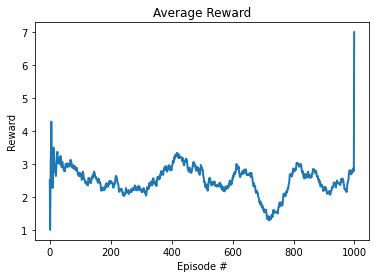

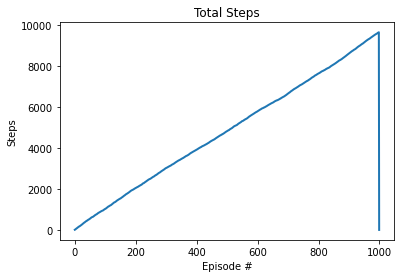

In [43]:
nfq_steps, nfq_r = result.T


fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
plt.plot(nfq_r, linewidth=2)
plt.ylabel('Reward')
plt.xlabel('Episode #')
ax1.set_title('Average Reward')

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
plt.plot(nfq_steps, linewidth=2)
plt.ylabel('Steps')
plt.xlabel('Episode #')
ax3.set_title('Total Steps')


plt.show()

In [44]:
env = gym.make('intersection-v0')
env = Monitor(env, './video', force=True, video_callable=lambda episode: True)

agent.load_models()
state = env.reset()
done = False

while not done:
    state = np.asarray(state).flatten()
    action, _, _ = agent.choose_action(state)
    obs, reward, done, info = env.step(action)
    state = obs
env.close()
show_video('./video')

... loading models ...


In [ ]:
print(*env.observation_space.shape)

15 7


In [ ]:
print(env.reward_range[0])

-inf
